# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/

In [48]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [49]:
DATASET_NAME = 'on-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [50]:
data = pd.read_csv(DATA_PATH, header=0, decimal=",", dtype={'SkuShort':'object'})
data = data.fillna(0)

#data['Date'] = data[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#data.Date = data.Date.map(datetime.datetime.toordinal)

#category
data.IsLockdown =  data.IsLockdown.astype('bool')

from sklearn.preprocessing import LabelEncoder, LabelBinarizer

data.SkuShort = LabelEncoder().fit_transform(data.SkuShort)
data.ProductGroup = LabelEncoder().fit_transform(data.ProductGroup)
data.PrimaryPack = LabelEncoder().fit_transform(data.PrimaryPack)
data.Country = LabelEncoder().fit_transform(data.Country)

#beer hl
data.PdtHl = data.PdtHl.round(0).astype('int64')
data.PrevWeekPdtHl1 = data.PrevWeekPdtHl1.round(0).astype('int64')
data.BgtHl = data.BgtHl.round(0).astype('int64')
data.SalesHl = data.SalesHl.round(-1).astype('int64')
data.PrevWeekSalesHl1 = data.PrevWeekSalesHl1.round(0).astype('int64')
data.PrevWeekSalesHl2 = data.PrevWeekSalesHl2.round(0).astype('int64')
data.PrevYearSalesHl1 = data.PrevYearSalesHl1.round(0).astype('int64')
data.PrevYearSalesHl2 = data.PrevYearSalesHl2.round(0).astype('int64')

data['AvgSalesHl1'] = data[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(0).astype('int64')
data['AvgSalesHl2'] = data[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(0).astype('int64')
data['AvgSalesHl3'] = data[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(0).astype('int64')

#round weather
data.AvgTemp = data.AvgTemp.round(0).astype('int64')
data.AvgRain = data.AvgRain.round(0).astype('int64')
data.AvgSun = data.AvgSun.round(0).astype('int64')

#data = data.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

# data.at[((data.Year == 2020) & (data.Week == 50)), 'IsLockdown'] = False
# data.at[((data.Year == 2020) & (data.Week == 51)), 'IsLockdown'] = False

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,...,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl,AvgSalesHl1,AvgSalesHl2,AvgSalesHl3
0,0,1,3,0,2016,1,5,-1,1,1,...,1902,2060,0,0,0,0,1902.0890,0,0,0
1,1,1,0,0,2016,1,5,-1,1,1,...,473,390,0,0,0,0,375.6472,0,0,0
2,2,1,0,0,2016,1,5,-1,1,1,...,3011,2540,0,0,0,0,2311.0085,0,0,0
3,3,1,0,0,2016,1,5,-1,1,1,...,4930,4520,0,0,0,0,4459.9005,0,0,0
4,5,1,1,0,2016,1,5,-1,1,1,...,46,10,0,0,0,0,40.8850,0,0,0


<AxesSubplot:xlabel='Year,Week'>

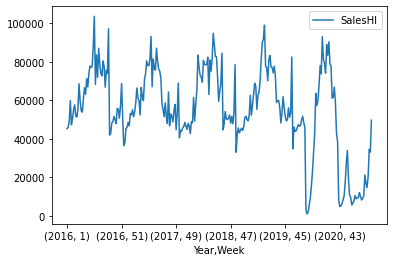

In [51]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'])

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SkuShort          25002 non-null  int32  
 1   ProductGroup      25002 non-null  int32  
 2   PrimaryPack       25002 non-null  int32  
 3   Country           25002 non-null  int32  
 4   Year              25002 non-null  int64  
 5   Week              25002 non-null  int64  
 6   NumberWorkdays    25002 non-null  int64  
 7   AvgTemp           25002 non-null  int64  
 8   AvgRain           25002 non-null  int64  
 9   AvgSun            25002 non-null  int64  
 10  IsLockdown        25002 non-null  bool   
 11  PdtHl             25002 non-null  int64  
 12  PrevWeekPdtHl1    25002 non-null  int64  
 13  BgtHl             25002 non-null  int64  
 14  SalesHl           25002 non-null  int64  
 15  PrevWeekSalesHl1  25002 non-null  int64  
 16  PrevWeekSalesHl2  25002 non-null  int64 

In [53]:
train = data[(data.Year <= 2019) | (data.Year == 2021) | ((data.Year == 2020) & (data.Week < 45))]
test = data[(data.Year == 2020) & (data.Week >= 45)]

# train = data[(data.Year <= 2020) | ((data.Year == 2021) & (data.Week < 10))]
# test = data[(data.Year == 2021) & (data.Week >= 10)]

#train = train.append([train[train.IsLockdown == 1]]*2, ignore_index=True)

cols_drop = ['SalesHl', 'OldPredSalesHl', 'BgtHl']
#'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year'

y_train = pd.DataFrame(train.SalesHl).round(0).astype(int)
X_train = train.drop(cols_drop, axis=1)

y_test = pd.DataFrame(test.SalesHl).round(0).astype(int)
X_test = test.drop(cols_drop, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.head()


y_oldPred = pd.DataFrame(test.OldPredSalesHl).fillna(0).round(0).astype(int)

In [54]:
from sklearn.preprocessing import MinMaxScaler

# from sklearn.preprocessing import RobustScaler
# scaler= RobustScaler()


scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error

from sklearn import ensemble, gaussian_process, isotonic, kernel_ridge, linear_model, neighbors, neural_network, svm, tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import QuantileTransformer, quantile_transform

# Create linear regression object

#NOT model = ensemble.AdaBoostRegressor()
#tree.DecisionTreeRegressor(random_state=0)
#model = ensemble.BaggingRegressor(base_estimator=svm.SVR(), bootstrap=True, bootstrap_features=False, n_estimators=200, oob_score=False, warm_start=True) # ON-TRADE: ,OFF-TRADE: 0.79
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
#model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True) # ON-TRADE: ,OFF-TRADE: 0.7933 
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#model = linear_model.LogisticRegression(max_iter=10)
#model = linear_model.LinearRegression(copy_X=False, fit_intercept=True, normalize=False, positive=False)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Ridge(max_iter=1000, copy_X=False, fit_intercept=True, normalize=True, solver='sparse_cg')# ON-TRADE: ,OFF-TRADE: 0.7876
#model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True) # ON-TRADE: ,OFF-TRADE:  0.7819 

#model = linear_model.ElasticNet(max_iter=2000, alpha=0.001, copy_X=False, fit_intercept=True, l1_ratio=1, normalize=True, positive=False, precompute=False, selection='random', warm_start=True)# ON-TRADE: ,OFF-TRADE: 0.7875
#model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
#model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
#model = linear_model.ARDRegression(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=False) # ON-TRADE: , OFF-TRADE: 0.7875
#model = linear_model.BayesianRidge(n_iter=500, compute_score=True, copy_X=True, fit_intercept=True, normalize=True) 

#model = linear_model.HuberRegressor(max_iter=500, epsilon=1.6, fit_intercept=True, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7805
#model = linear_model.RANSACRegressor(max_trials=500) #ON-TRADE: , OFF-TRADE: 0.7225
#model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
#model = linear_model.TweedieRegressor(max_iter=500, alpha=0.05, fit_intercept=False, link='auto', power=0, warm_start=True) # ON-TRADE: , OFF-TRADE: 0.7871
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

#model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049

#param_grid = dict(criterion=['mse','mae'])
# #alpha=[1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001],fit_intercept=[True, False], verbose=[True, False], normalize=[True, False], precompute=[True, False], copy_X=[True, False], fit_path=[True, False], positive=[True, False], jitter=[True, False]
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)


hgbModel = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)
mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
rfModel = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=3, bootstrap=True, criterion='mse', oob_score=True)
#knModel = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1)
# sgdModel = linear_model.SGDRegressor(max_iter=1500, early_stopping=False, alpha=0.0001, average=True, epsilon=0.1,eta0=0.01, fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling', loss='huber', penalty='l2', power_t=0.1, shuffle=True, warm_start=True)

model = ensemble.VotingRegressor([('hgb', hgbModel), ('mlp', mlpModel), ('rf', rfModel)], weights=[1, 0.5, 0.7], n_jobs=3)

#model = lgb.LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=6)


# Train the model using the training sets
model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_oldPred))

# print(f'The number of iterations as selected by early stopping: {model.n_iter_}')
# print(f'The scores at each iteration on the training data: {model.train_score_}')
# print(f'The scores at each iteration on the held-out validation data: {model.validation_score_}')
# print(f'Boolean mask for the categorical features: {model.is_categorical_}')

#on-trade
#LGBMRegressor = 0.2801, 0.7314
#MLPRegressor = 0.1532, 0.2210
#VotingRegressor = 0.5367, 0.7072
#HistGradientBoostingRegressor = 0.4634, 0.8241
#RandomForestRegressor = 0.4809, 0.7280

#off-trade
#LGBMRegressor = , 0.8537
#MLPRegressor = 0.7418, 0.7768
#VotingRegressor = 0.8442, 0.8572
#HistGradientBoostingRegressor = 0.8640, 0.8470
#RandomForestRegressor = 0.8557, 0.8418

on-trade
Coefficient of determination: 0.5656
Maximum residual error: 2786.9405
Old Coefficient of determination: 0.4993
Old Maximum residual error: 2894.0000


In [36]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2020 45            69.3%          97.0%              27.7%
     46            53.3%          85.4%              32.1%
     47            58.6%          70.4%              11.8%
     48            44.4%          96.4%              52.0%
     49            40.4%          57.2%              16.8%
     50            60.5%          49.6%             -10.8%
     51            49.9%          82.1%              32.3%
     52            62.8%          78.2%              15.4%
     53            87.0%          75.1%             -11.9%
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2020          76.9%          83.1%               6.3%


## Model analysis

In [11]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)


# forest_importances = pd.Series(result.importances_mean, index=feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [37]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

feature_names = X_train.columns.tolist()
examples_numpy = pd.concat([X_train.sample(n=50), X_test.sample(n=50)]).to_numpy()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=feature_names)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

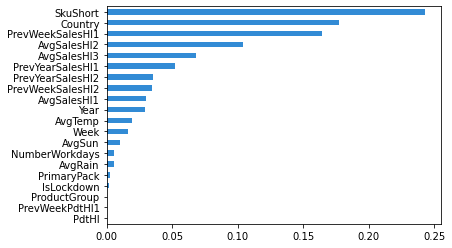

In [38]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [15]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [16]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [17]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [18]:
# shap.plots.force(shap_values[0])

In [19]:
# shap.plots.force(shap_values)

In [20]:
# shap.plots.scatter(shap_values, color=shap_values)

In [21]:
# shap.plots.bar(shap_values)

In [22]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [23]:
result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [24]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/on-trade_model.joblib']

## Use model

In [26]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363